In [1]:
# !wget https://zenodo.org/records/12112951/files/dataset.zip
# !unzip dataset.zip

In [2]:
import os
import numpy as np
from skimage.util import view_as_windows
import scipy.signal
import matplotlib.pyplot as plt

In [3]:
def hipass_filter(data, sampling_frequency, cutoff, order):
    cutoff = cutoff/(sampling_frequency/2)
    assert cutoff < 1 # cutoff given too high for nyquist rate
    installed_filter_b, installed_filter_a = scipy.signal.butter(N=order,Wn=cutoff,btype="highpass")
    
    filtered_data = scipy.signal.filtfilt(installed_filter_b,
                                            installed_filter_a,
                                            data.T,
                                            axis=0)
    return filtered_data.T

In [4]:
path = 'dataset/'
window = 4 #seconds
emg_sr = 1259.2592592592594 #Hz
imu_sr = 148.14814814814815 #Hz
window_step = 1/4 #0.25sec
n_sensors = 8
cutoff = 50
order = 2

In [5]:
counter = 0
fcounter = 0
tduration = 0

for sub in os.listdir(path):
    print(sub)
    s = int(''.join([s for s in [*sub] if s.isdigit()]))
    for act in os.listdir(path+sub):
        for tr in os.listdir(path+sub+'/'+act):
            fcounter+=1
            emg = np.load(path+sub+'/'+act+'/'+tr+'/'+'emg.npy')
            imu = np.load(path+sub+'/'+act+'/'+tr+'/'+'imu.npy')
            duration = emg.shape[1]/emg_sr
            tduration += duration
            if int(act)>5:
                # avoid having several walking examples we use a larger stride
                window_step = 1/2
            else:
                window_step = 1/4
            
            if duration<=0:
                continue
            elif duration<window:
                emg_segments = np.zeros((1,n_sensors,int(np.round(window*emg_sr))))
                emg_segments[:,:,:emg.shape[1]] = emg

                imu_segments = np.zeros((1,6*n_sensors,int(np.round(window*imu_sr))))
                imu_segments[:,:,:imu.shape[1]] = imu
            else:
                emg_segments = view_as_windows(np.array(emg), window_shape=(n_sensors,int(np.round(window*emg_sr))),
                                        step=int(emg_sr*window_step))[0]

                imu_segments = view_as_windows(np.array(imu), window_shape=(6*n_sensors,int(np.round(window*imu_sr))),
                                        step=int(imu_sr*window_step))[0]

            ### Check if EMG shape matches the IMU shape!
            assert len(emg_segments)==len(imu_segments)
            counter+=len(emg_segments)


Subject_7
Subject_8
Subject_18
Subject_31
Subject_4
Subject_13
Subject_20
Subject_12
Subject_24
Subject_5
Subject_22
Subject_30
Subject_14
Subject_23
Subject_25
Subject_9
Subject_6
Subject_3
Subject_10
Subject_15
Subject_1
Subject_27
Subject_28
Subject_2
Subject_26
Subject_29
Subject_17
Subject_21
Subject_19
Subject_11
Subject_16


In [6]:
print('Average duration:', tduration/fcounter)
print('Total duration:', tduration)
print('Total amount of files:', fcounter)
print('Total amount of segmented files:', counter)
print('Total EMG values:', tduration*n_sensors*emg_sr)
print('Total IMU values:', tduration*n_sensors*imu_sr*6)

Average duration: 4.175805594721087
Total duration: 8710.730470588187
Total amount of files: 2086
Total amount of segmented files: 4833
Total EMG values: 87752543.99999952
Total IMU values: 61942972.235293776


In [7]:
# instatiate two tensors with zeros to be filled later with IMU and EMG segments
global_emg_segments = np.zeros((counter,n_sensors,int(window*emg_sr)))
global_imu_segments = np.zeros((counter,6*n_sensors,int(np.round(window*imu_sr))))

subjects = []
labels = []
sessions = []
current_seg_id = 0

for sub in os.listdir(path):
    print(sub)
    s = int(''.join([s for s in [*sub] if s.isdigit()]))
    for act in os.listdir(path+sub):
        for tr in os.listdir(path+sub+'/'+act):
            emg = np.load(path+sub+'/'+act+'/'+tr+'/'+'emg.npy')
            #emg = bp_filter(emg_sr,emg)
            imu = np.load(path+sub+'/'+act+'/'+tr+'/'+'imu.npy')
            duration = emg.shape[1]/emg_sr
            if int(act)>5:
                # avoid having several walking examples we use a larger stride
                window_step = 1/2
            else:
                window_step = 1/4
            if duration<=0:
                continue
            elif duration<window:
                emg = np.clip(hipass_filter(emg,emg_sr,cutoff,order),a_min=-0.3,a_max=0.3)
#                 emg = np.clip(bp_filter(emg_sr,emg),a_min=-0.3,a_max=0.3)
                emg_segments = np.zeros((1,n_sensors,int(np.round(window*emg_sr))))
                emg_segments[:,:,:emg.shape[1]] = emg

                imu_segments = np.ones((1,6*n_sensors,int(np.round(window*imu_sr))))
                imu_segments = imu_segments*np.expand_dims(imu[:,-1],-1)
                imu_segments[:,:,:imu.shape[1]] = imu
            else:
                emg = np.clip(hipass_filter(emg,emg_sr,cutoff,order),a_min=-0.3,a_max=0.3)
                emg_segments = view_as_windows(np.array(emg), window_shape=(n_sensors,int(np.round(window*emg_sr))),
                                        step=int(emg_sr*window_step))[0]

                imu_segments = view_as_windows(np.array(imu), window_shape=(6*n_sensors,int(np.round(window*imu_sr))),
                                        step=int(imu_sr*window_step))[0]

            next_seg_id = current_seg_id + len(emg_segments)
            global_emg_segments[current_seg_id:next_seg_id,:,:] = emg_segments
            global_imu_segments[current_seg_id:next_seg_id,:,:] = imu_segments

            subjects+=[s]*len(emg_segments)
            labels+=[int(act)]*len(emg_segments)
            sessions+=[path+sub+'/'+act+'/'+tr]*len(emg_segments)

            current_seg_id += len(emg_segments)

Subject_7
Subject_8
Subject_18
Subject_31
Subject_4
Subject_13
Subject_20
Subject_12
Subject_24
Subject_5
Subject_22
Subject_30
Subject_14
Subject_23
Subject_25
Subject_9
Subject_6
Subject_3
Subject_10
Subject_15
Subject_1
Subject_27
Subject_28
Subject_2
Subject_26
Subject_29
Subject_17
Subject_21
Subject_19
Subject_11
Subject_16


In [8]:
assert global_emg_segments.shape[0]==global_imu_segments.shape[0]

In [9]:
emg = global_emg_segments
imu = global_imu_segments

labels = np.array(labels)
subjects = np.array(subjects)
sessions = np.array(sessions)

In [10]:
np.save('emg_all.npy',emg)
np.save('imu_all.npy',imu)
np.save('labels_all.npy',labels)
np.save('subjects_all.npy',subjects)
np.save('sessions_all.npy',sessions)

### Save in .mat format (MATLAB)

In [11]:
from scipy.io import savemat

# save the whole dataset in .mat
dataset_dict = {'emg':emg, 'imu':imu, 'labels':labels, 'subjects':subjects, 'trials':sessions}
savemat('dataset.mat', dataset_dict)

### Rolling RMS

In [12]:
def rolling_rms(x, N):
    xc = np.cumsum(abs(np.array(x))**2)
    return np.sqrt((xc[N:] - xc[:-N]) / N)

In [13]:
N = 200

rms_emg = np.zeros((emg.shape[0],emg.shape[1],emg.shape[2]-N))
for i in range(len(rms_emg)):
    for j in range(8):
        rms_emg[i,j,:] = rolling_rms(emg[i,j,:],N)

In [14]:
left = [1,  2,  3,  6,  7, 12, 16, 17, 18, 20, 21, 23, 24, 27, 30] #1
right = [4,  5,  8,  9, 10, 11, 13, 14, 15, 19, 20, 21, 22, 25, 26, 28, 29, 31] #0

In [15]:
foot = np.zeros(len(subjects),dtype=int)
strong_foot = np.zeros(len(subjects),dtype=int)
i_foot = []
h_foot = []
for i in range(len(subjects)):
    if subjects[i] in right:
        foot[i] = 0
        strong_foot[i] = 4
        i_foot.append('right')
        h_foot.append('left')
    else:
        foot[i] = 4
        strong_foot[i] = 0
        i_foot.append('left')
        h_foot.append('right')

subject: 7
activity: 1


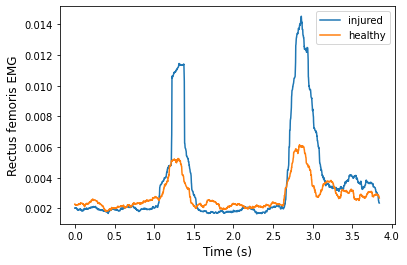

In [16]:
ind = 108
print('subject:',subjects[108])
print('activity:',labels[ind])

time = np.arange(0, len(rms_emg[ind,0,:]))/emg_sr
plt.plot(time,rms_emg[ind,foot[108],:])
plt.plot(time,rms_emg[ind,strong_foot[108],:])
plt.legend(["injured", "healthy"], loc ="upper right")
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Rectus femoris EMG', fontsize=12)

plt.savefig('Rectus_femoris_EMG_squat.png', dpi=300)

plt.show()

subject: 3
activity: 2


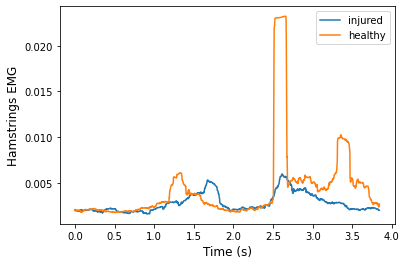

In [17]:
ind = 2675
print('subject:',subjects[ind])
print('activity:',labels[ind])

time = np.arange(0, len(rms_emg[ind,0,:]))/emg_sr
plt.plot(time,rms_emg[ind,foot[108]+1,:])
plt.plot(time,rms_emg[ind,strong_foot[108]+1,:])
plt.legend(["injured", "healthy"], loc ="upper right")
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Hamstrings EMG', fontsize=12)

plt.savefig('hamstrings_EMG_squat.png', dpi=300)

plt.show()

subject: 29
activity: 3 4 5


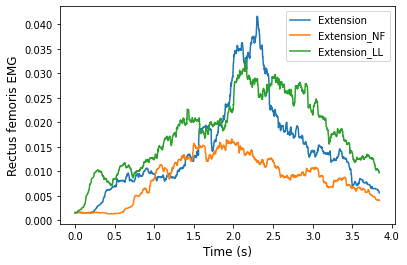

In [18]:
ind = 3784
ind_2 = 3698
ind_3 = 3839
print('subject:',subjects[ind])
print('activity:',labels[ind], labels[ind_2], labels[ind_3])

time = np.arange(0, len(rms_emg[ind,0,:]))/emg_sr
plt.plot(time,rms_emg[ind,foot[ind]+0,:])
plt.plot(time,rms_emg[ind_2,foot[ind_2]+0,:])
plt.plot(time,rms_emg[ind_3,foot[ind_3]+0,:])
plt.legend(["Extension", "Extension_NF", "Extension_LL"], loc ="upper right")
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Rectus femoris EMG', fontsize=12)

plt.savefig('rectus_femoris_EMG_extension.png', dpi=300)

plt.show()

subject: 29
activity: 3 4 5


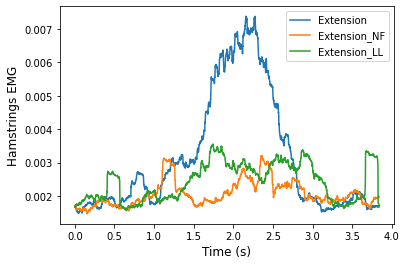

In [19]:
ind = 3784
ind_2 = 3698
ind_3 = 3839
print('subject:',subjects[ind])
print('activity:',labels[ind], labels[ind_2], labels[ind_3])

time = np.arange(0, len(rms_emg[ind,0,:]))/emg_sr
plt.plot(time,rms_emg[ind,foot[ind]+1,:])
plt.plot(time,rms_emg[ind_2,foot[ind_2]+1,:])
plt.plot(time,rms_emg[ind_3,foot[ind_3]+1,:])
plt.legend(["Extension", "Extension_NF", "Extension_LL"], loc ="upper right")
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Hamstrings EMG', fontsize=12)

plt.savefig('hamstrings_EMG_extension.png', dpi=300)

plt.show()

subject: 26
activity: 7


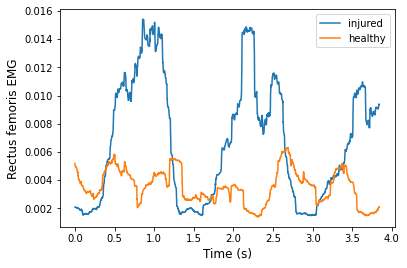

In [20]:
ind = 3540

print('subject:',subjects[ind])
print('activity:',labels[ind])

time = np.arange(0, len(rms_emg[ind,0,:]))/emg_sr
plt.plot(time,rms_emg[ind,foot[ind]+0,:])
plt.plot(time,rms_emg[ind,strong_foot[ind]+0,:])
plt.legend(["injured", "healthy"], loc ="upper right")
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Rectus femoris EMG', fontsize=12)

plt.savefig('Rectus_femoris_EMG_walking_nfe.png', dpi=300)

plt.show()

subject: 26
activity: 8


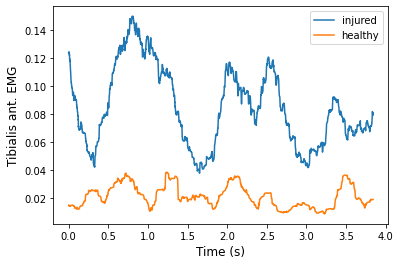

In [21]:
ind = 3635
print('subject:',subjects[ind])
print('activity:',labels[ind])

time = np.arange(0, len(rms_emg[ind,0,:]))/emg_sr
plt.plot(time,rms_emg[ind,foot[ind]+2,:])
plt.plot(time,rms_emg[ind,strong_foot[ind]+2,:])
plt.legend(["injured", "healthy"], loc ="upper right")
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Tibialis ant. EMG', fontsize=12)

plt.savefig('tibialis_ant._EMG.png', dpi=300)

plt.show()